## Second task

Скачайте датасет с kaggle-соревнования Kaggle: Facial Keypoints Detection
Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета и посчитайте метрики для Ground-Truth точек которые эквивалентны точкам из модели (в opencv 68-point модель, в kaggle разметка для 15-точек.

Подумайте, предложите метрики, которые стоит посчитать для этой задачи. Мы хотим при помощи этих метрик оценить несколько факторов:
* оценить точность детектирования каждой из точек и всех точек в среднем
* оценить точность позиционирования (насколько точки смещаются относительно GT) для каждой landmark и в среднем
Отберите и визуализируйте (изображение + точки Ground Truth + Predicts) 3-5 изображений с самым высоким качеством детектирования и с самым низким.

In [8]:
import zipfile
from tqdm import tqdm

import cv2
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
with zipfile.ZipFile("kaggle/training.zip") as zip_h:
    zip_h.extractall("kaggle")

In [4]:
def string_to_image(image_str):
    image = np.fromiter(map(float, image_str.split()), dtype=np.uint8)
    image = image.reshape(96, 96)
    return image

In [7]:
training_csv = "kaggle/training.csv"
df = pd.read_csv(training_csv)
df.dropna(inplace=True)
df["image_r"] = df["Image"].apply(string_to_image)

In [9]:
def detect_landmarks(image_from_str):
    img_rgb = cv2.cvtColor(image_from_str, cv2.COLOR_BGR2RGB)
    faces = detector(img_rgb)
    if len(faces) == 0:
        return None
    shape = predictor(image, faces[0])
    landmarks = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
    return landmarks


def calculate_metrics(detected_landmarks, control_points):
    errors = []
    for ctrl_pt in control_points:
        distances = np.linalg.norm(detected_landmarks - ctrl_pt, axis=1)
        min_dist = np.min(distances)
        errors.append(min_dist)
    
    rmse = np.sqrt(np.mean(np.array(errors) ** 2))
    mae = np.mean(errors)

    return rmse, mae


def visualize_samples(image, detected_landmarks, control_points):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')

    plt.scatter(*zip(*detected_landmarks), s=10, c="blue", label="Pred", marker="x")
    plt.scatter(*zip(*control_points), s=20, c="green", label="GT", marker="o")

    plt.axis("off")
    plt.show()

In [12]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [13]:
results = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    image = row["image_r"]
    detected_landmarks = detect_landmarks(image)
    if detected_landmarks is None:
        continue
    control_points = [
        (row[feature], row[feature.replace("_x", "_y")])
        for feature in df.columns[:-2:2]
    ]
    
    detected_landmarks = np.array(detected_landmarks)
    control_points = np.array(control_points)
    rmse, mae = calculate_metrics(detected_landmarks, control_points)
    results.append((i, rmse, mae))

100%|███████████████████████████████████| 2140/2140 [00:07<00:00, 281.76it/s]


Best Predictions
Image 1640
RMSE: 1.336
MAE: 1.062


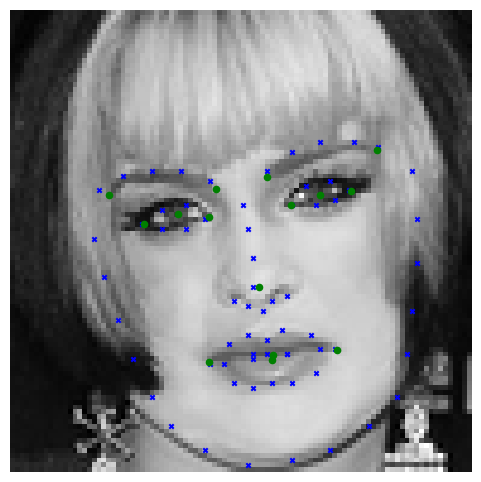

Image 2045
RMSE: 1.346
MAE: 1.152


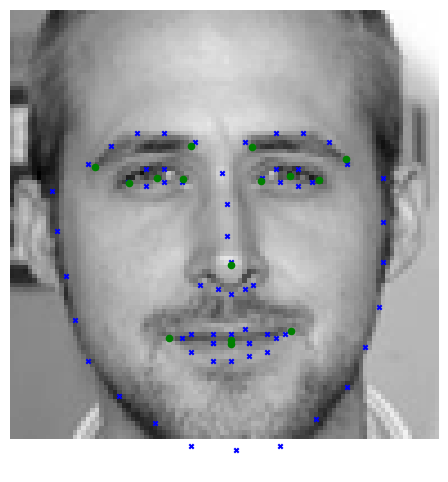

Image 1681
RMSE: 1.358
MAE: 1.167


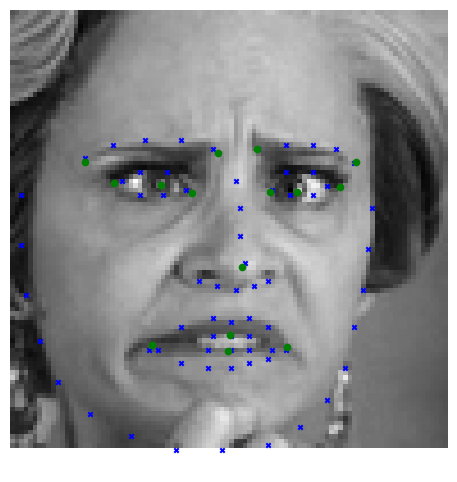

Image 1911
RMSE: 1.367
MAE: 1.256


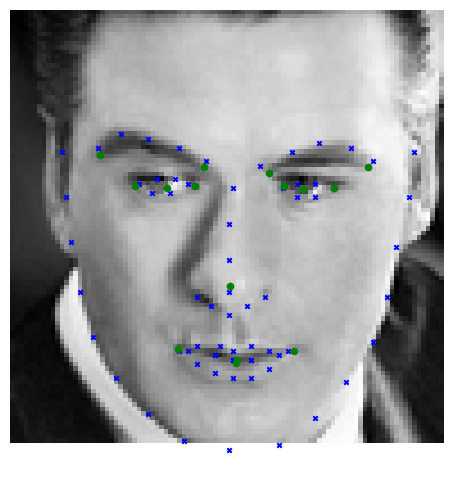

Image 375
RMSE: 1.370
MAE: 1.224


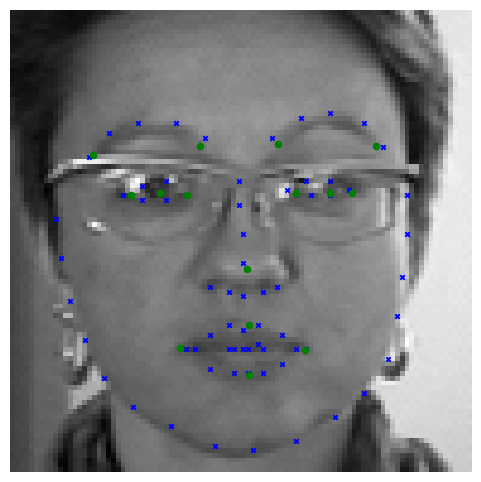

Worst Predictions
Image 1371
RMSE: 4.353
MAE: 3.930


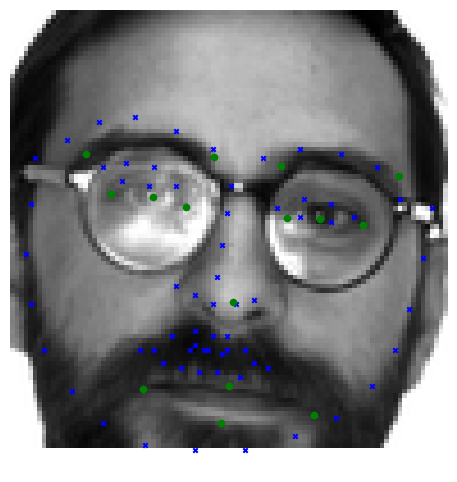

Image 1996
RMSE: 4.457
MAE: 3.768


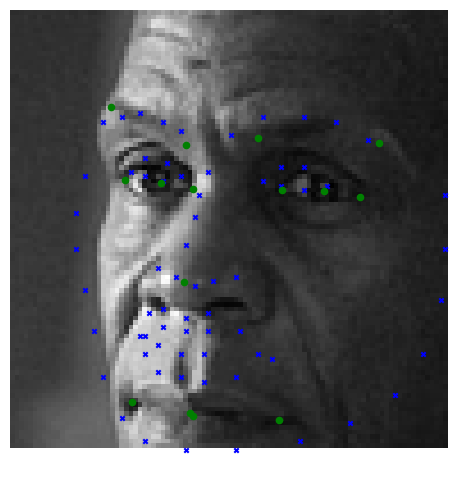

Image 2159
RMSE: 4.464
MAE: 3.636


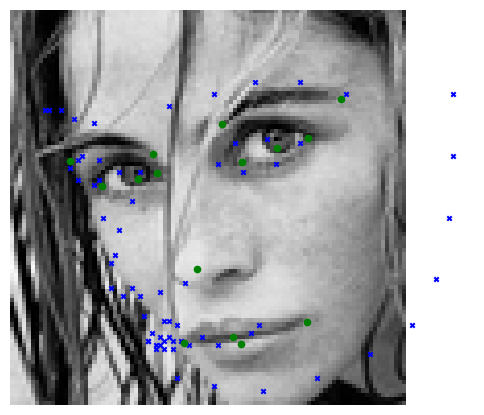

Image 1932
RMSE: 4.556
MAE: 3.811


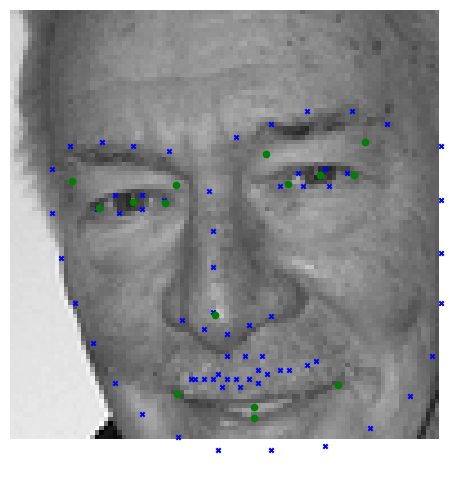

Image 1953
RMSE: 7.733
MAE: 6.809


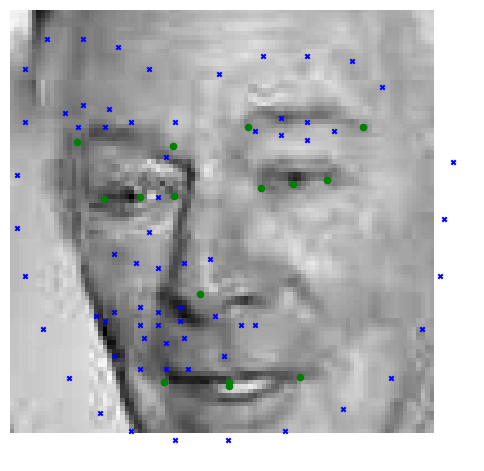

In [15]:
results.sort(key=lambda x: x[1:])
best = results[:5]
worst = results[-5:]

for group, title in (
    (best, "Best Predictions"), (worst, "Worst Predictions")
):
    print(title)
    for item in group:
        i, rmse, mae = item
        print(f"Image {i}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAE: {mae:.3f}")
        image = df.loc[i]["image_r"]
        detected_landmarks = detect_landmarks(image)
        control_points = [
            (df.loc[i][feature], df.loc[i][feature.replace("_x", "_y")])
            for feature in df.columns[:-2:2]
        ]
        visualize_samples(image, detected_landmarks, control_points)